# End to End Optical Music Recognition with CRNN

## Importing libraries

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed
# tf.compat.v1.disable_eager_execution()
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Layer
# from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, Permute, Bidirectional
# from tensorflow.keras.layers import Reshape, Lambda, BatchNormalization, LSTM
# from tensorflow.python.keras.layers.merge import add, concatenate
# from tensorflow.python.keras.layers.recurrent import LSTM
# from tensorflow.keras.layers import CuDNNLSTM
from primus import CTC_PriMuS
import ctc_utils
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

# Building the model

In [3]:
def default_model_params(img_height, vocabulary_size):
    params = dict()
    params['img_height'] = img_height
    params['img_width'] = None
    params['batch_size'] = 16
    params['img_channels'] = 1
    params['conv_blocks'] = 2
    params['conv_filter_n'] = [32, 64]
    params['conv_filter_size'] = [ [3,3], [3,3] ]
    params['conv_pooling_size'] = [ [2,2], [2,2] ]
    params['rnn_units'] = 32
    params['rnn_layers'] = 1
    params['vocabulary_size'] = vocabulary_size
    return params

In [4]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost
        # self.loss_fn = K.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64") # 16
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        # print("Y_pred shape:  ",y_pred.shape)
        # print("Y_true shape:  ",y_true.shape)
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [5]:
#model
def buildModel(params, input_width, rnn_layers = 2, rnn_units = 128):
    input_shape = (params['img_height'],params['img_width'], params['img_channels'])

    inputs = layers.Input(type_spec=tf.TensorSpec(shape=[None, params['img_height'], input_width, 1], dtype=tf.float32), name = "image" )
    # inputs = layers.Input(name='image', shape=input_shape, dtype='float32')

    labels = layers.Input(type_spec=tf.TensorSpec(shape=[None, None], dtype=tf.float32), name = "label" )
    # x = layers.Reshape((params['img_height'], input_width, 1), name="expand_dim")(inputs)
    x = layers.Conv2D(
        filters=32,
        kernel_size= [params['conv_filter_n'][0], params['conv_filter_n'][0]],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(inputs)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.MaxPool2D(pool_size=params['conv_pooling_size'][0], strides = params['conv_pooling_size'][0], name='max1')(x)

    x = layers.Conv2D(
        filters=64,
        kernel_size=[params['conv_filter_n'][1], params['conv_filter_n'][1]],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.MaxPool2D(pool_size=params['conv_pooling_size'][1], strides = params['conv_pooling_size'][1], name='max2')(x)
    print(x.shape)
    x = layers.Reshape((-1, x.shape[-3] * x.shape[-1]))(x)

    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.35)(x)

    num_classes = params['vocabulary_size'] + 1
    y_pred = layers.Dense(num_classes, kernel_initializer='he_normal',name='dense2', activation='softmax')(x) #(None, 32, 63)        
    output = CTCLayer(name="ctc_loss")(labels, y_pred)
    model = Model([inputs,labels], output, name="OMR")
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    model.compile(optimizer = optimizer)
    # model.compile(optimizer=opt, loss=CTCLoss)
    return model

## Loading Dataset

In [6]:
img_height = 128
corpus_dirpath = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/primusCalvoRizoAppliedSciences2018/"
corpus_filepath = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/train.txt"
dictionary_path = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/vocabulary_semantic.txt"
test_set_path = "C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/test.txt"

# primus = CTC_PriMuS(corpus_dirpath,corpus_filepath,dictionary_path, True, val_split = 0.2)

# corpus_dirpath = "/content/primusCalvoRizoAppliedSciences2018/"
# corpus_filepath = "/content/train.txt"
# dictionary_path = "/content/vocabulary_semantic.txt"


In [7]:
# # delete N lines from the train/test txt files for training purposes
# with open(r"C:/Users/steli/DeepLearning/Project/tf-end-to-end/Data/train.txt", 'r+') as fp:
#     lines = fp.readlines()
#     t = int(len(lines))
#     print(t)
#     # print(len(lines))
#     fp.seek(0)
#     fp.truncate()
#     fp.writelines(lines[:-200])

In [8]:
# Get Data
image_paths = []
image_texts = []

class PriMuS_Data:
    def __init__(self, corpus_dirpath, corpus_filepath, dictionary_path):
        self.corpus_dirpath = corpus_dirpath

        # Corpus
        corpus_file = open(corpus_filepath,'r')
        self.corpus_list = corpus_file.read().splitlines()
        corpus_file.close()

        self.current_idx = 0

        # Dictionary
        self.word2int = {}
        self.int2word = {}
            
        dict_file = open(dictionary_path,'r')
        dict_list = dict_file.read().splitlines()
        for word in dict_list:
            if not word in self.word2int:
                word_idx = len(self.word2int)
                self.word2int[word] = word_idx
                self.int2word[word_idx] = word

        dict_file.close()

        self.vocabulary_size = len(self.word2int)
    
    def get_vocabulary_size(self):
        return self.vocabulary_size
        
    def get_data(self):
        return self.corpus_list

    def encode_seqs(self, seqs):
        encoded = []
        for seq in seqs:
            new_seq=[]
            for sym in seq:
                new_seq.append(self.word2int[sym])
            encoded.append(new_seq)
        return encoded

    def decode_seqs(self, seqs): # [1,2,3,4,..] -> "clef\tC-note"
        decoded = []
        for seq in seqs:
            new_seq=""
            for sym in seq:
                try:
                    new_seq+= self.int2word[sym] + "\t"
                except KeyError:
                    continue
            new_seq = new_seq[:-1]
            decoded.append(new_seq)
        return decoded

    def get_test(self):
        obj = self.trim_ds(val_split=1) 
        return {"images": obj['train']['images'], "text":obj['train']['text']}

    def trim_ds(self, val_split = 0.9):
        folder_path = self.corpus_dirpath
        list_of_files = self.corpus_list #10,000 filenames

        image_paths = [self.corpus_dirpath+f"{x}/{x}.png" for x in self.corpus_list] # list of image paths
        text_paths = [self.corpus_dirpath+f"{x}/{x}.semantic" for x in self.corpus_list]

        image_texts = [] # list of strings

        for path in text_paths:
            with open(path, "r") as file:
                image_texts.append(file.readline().split())

        image_texts = self.encode_seqs(image_texts)

        max_label_len = max([len(seq) for seq in image_texts])
        print(max_label_len)
        padded_image_texts = pad_sequences(image_texts, maxlen=max_label_len, padding='post', value= self.vocabulary_size + 1)

        # TODO: do line 17 from the link : https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb

        # TODO: Use self.word2int to encode each element of the lists in image_texts
        # Input image_texts = [  ['clef','C-note'] , [.......], ....]
        # Final image_texts = [  [5,3] , [.......], ....]
        # if 'clef' == 5, 'C-note' == 3 in word2int dictionary
        # Also add padding using the function below so length of each element is consistent

        # from tensorflow.keras.preprocessing.sequence import pad_sequences
        # padded_image_texts = list(map(encode_to_labels, image_texts))
        # padded_image_texts[0]


        train_image_paths = image_paths[ : int(len(image_paths) * val_split)]
        train_image_texts = padded_image_texts[ : int(len(padded_image_texts) * val_split)]

        val_image_paths = image_paths[int(len(image_paths) * val_split) : ]
        val_image_texts = padded_image_texts[int(len(padded_image_texts) * val_split) : ]

        return {"train":{"images":train_image_paths, "text": train_image_texts}, "val":{"images":val_image_paths, "text": val_image_texts}}
    


In [9]:
data_obj = PriMuS_Data(corpus_dirpath, corpus_filepath, dictionary_path)
lst = data_obj.trim_ds()

56


In [10]:
data_obj_test = PriMuS_Data(corpus_dirpath, test_set_path, dictionary_path)
lst_test = data_obj_test.get_test()

37


## Preprocessing data for training

In [11]:
# Resize images to desired dimensions with unknown width
def resize_no_width(image, height):
    width = int(float(height * image.shape[1]) / image.shape[0])
    sample_img = cv2.resize(image, (width, height))
    return sample_img


# Pre-process a single image sample(resize/normalize/max_width resize)
def process_single_sample(img_path, label,max_width = 30):
    params = default_model_params(img_height,primus.vocabulary_size)
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img,[params['img_height'], max_width])
    # TODO: Get height from params, calculate width from max of all images
    return {"image": img, "label": label}


In [12]:
batch_size = 16


image_widths = [cv2.imread(img).shape[1] for img in lst["train"]["images"]]
image_widths_2 = [cv2.imread(img).shape[1] for img in lst["val"]["images"]]
image_widths_3 = [cv2.imread(img).shape[1] for img in lst["train"]["images"]]

max_image_width = max(image_widths + image_widths_2 + image_widths_3)

print(max_image_width)
# Parameterization
img_height = 128
params = default_model_params(img_height,data_obj.vocabulary_size)
max_epochs = 100
dropout = 0.5
# Model
model = buildModel(params,input_width = max_image_width)
model.summary()

# Pre-process a single image sample(resize/normalize/max_width resize)
def process_single_sample(img_path, label):
    params = default_model_params(img_height,data_obj.vocabulary_size)
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img,[params['img_height'], max_image_width])
    # TODO: Get height from params, calculate width from max of all images
    return {"image": img, "label": label}
# train_dataset = train_dataset.map(process_single_sample(max_width = max_image_width))

# processed_images = [process_single_sample(img,label,max_image_width) for img,label in zip(lst["train"]["images"], lst["train"]["text"])]

# train_dataset = tf.data.Dataset.from_tensor_slices((lst['train']['images'], lst['train']['text']))

# train_dataset = (
#     train_dataset.map(
#         process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
#     )
#     .batch(batch_size)
#     .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# )

# validation_dataset = tf.data.Dataset.from_tensor_slices((lst['val']['images'], lst['val']['text']))
# validation_dataset = (
#     validation_dataset.map(
#         process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
#     )
#     .batch(batch_size)
#     .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# )
def tfdata_generator_train(batch_size= batch_size):
  '''Construct a data generator using `tf.Dataset`. '''
  train_dataset = tf.data.Dataset.from_tensor_slices((lst['train']['images'], lst['train']['text']))
  train_dataset = train_dataset.map(process_single_sample)
  train_dataset = train_dataset.batch(batch_size)
  # train_dataset = train_dataset.repeat()
  train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return train_dataset

def tfdata_generator_val(batch_size= batch_size):
  '''Construct a data generator using `tf.Dataset`. '''
  val_dataset = tf.data.Dataset.from_tensor_slices((lst['val']['images'], lst['val']['text']))
  val_dataset = val_dataset.map(process_single_sample)
  val_dataset = val_dataset.batch(batch_size)
  # val_dataset = val_dataset.repeat()
  val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return val_dataset

def tfdata_generator_test(batch_size= batch_size):
  '''Construct a data generator using `tf.Dataset`. '''
  test_dataset = tf.data.Dataset.from_tensor_slices((lst_test['images'], lst_test['text']))
  test_dataset = test_dataset.map(process_single_sample)
  test_dataset = test_dataset.batch(batch_size)
  # train_dataset = train_dataset.repeat()
  test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return test_dataset


2003
(None, 16, 125, 64)
Model: "OMR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 2003,   0           []                               
                                1)]                                                               
                                                                                                  
 conv_1 (Conv2D)                (None, 64, 1002, 32  32768       ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 conv_1_bn (BatchNormalization)  (None, 64, 1002, 32  128        ['conv_1[0][0]']                 
                                )                                      

c:\Users\steli\.conda\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
train_dataset = tfdata_generator_train()
validation_dataset = tfdata_generator_val()
test_dataset = tfdata_generator_test()

## Training the model

In [14]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='../models/model500.ckpt', save_weights_only=True, save_best_only = True , verbose= 1),
    tf.keras.callbacks.TensorBoard(log_dir='../data/logs'),
]

In [15]:
# Define the number of epochs.
epochs = 500

# Train the model
# history = model.fit(
#     train_dataset,
#     # tf.compat.v1.data.make_one_shot_iterator(train_dataset).get_next(),
#     # validation_data = tf.compat.v1.data.make_one_shot_iterator(validation_dataset).get_next(),
#     validation_data = validation_dataset,
#     epochs=epochs,
#     callbacks=my_callbacks
# )
# model.save_weights()

In [16]:
# Save model
# model.save_weights("../models/model_500epoch.ckpt")

In [17]:
# Load model
model.load_weights("../models/model500.ckpt")

In [18]:
# new_model = tf.keras.models.load_model('../models/model.01-105.60.h5', custom_objects={'CTCLayer': CTCLayer})
# new_model = tf.keras.models.load_model('../models/model_1epoch.hdf5', custom_objects={'CTCLayer': CTCLayer})

In [19]:
# Loading Model
# model = tf.keras.models.load_model('../models/model.01-105.60.h5', custom_objects={'CTCLayer': CTCLayer})
# Loading Weights

## Predicting using loaded model

In [20]:
def ctc_decoder(preds):
    pred_indcies = np.argmax(preds, axis=2)
    decoded_pred = data_obj.decode_seqs(pred_indcies)
    return decoded_pred

def ground_truth_decoder(truth):
    return data_obj.decode_seqs(truth)

In [21]:
ground_truth = lst_test["text"]
print(ground_truth_decoder(ground_truth)[0])

clef-C1	keySignature-EbM	timeSignature-2/4	multirest-23	barline	rest-quarter	rest-eighth	note-Bb4_eighth	barline	note-Bb4_quarter.	note-G4_eighth	barline	note-Eb5_quarter.	note-D5_eighth	barline	note-C5_eighth	note-C5_eighth	rest-quarter	barline


In [22]:
preds = model.predict(test_dataset)
pred_strings = ctc_decoder(preds)
pred_strings

['clef-C1\tkeySignature-DM\ttimeSignature-3/8\tmultirest-11\tbarline\trest-quarter\trest-quarter\tbarline',
 'clef-C1\tkeySignature-BbM\ttimeSignature-C\tmultirest-5\tbarline\tbarline\trest-quarter\tbarline\tbarline',
 'clef-C4\tkeySignature-BbM\ttimeSignature-C\tmultirest-8\tbarline\trest-quarter\tbarline',
 'clef-G2\tkeySignature-AM\ttimeSignature-2/4\tbarline',
 'clef-C1\tkeySignature-EbM\ttimeSignature-C\tmultirest-4\tbarline\tbarline\tbarline\tbarline\tbarline\tbarline\tbarline\tbarline\tbarline',
 'clef-C1\ttimeSignature-C\trest-eighth\trest-eighth\trest-eighth',
 'clef-G2\tkeySignature-GM\ttimeSignature-C\tbarline\tnote-A5_quarter\tnote-A5_quarter\tnote-A5_quarter\tnote-A5_quarter\tnote-A5_quarter\tnote-G5_quarter',
 'clef-G2\tkeySignature-EbM\ttimeSignature-C\tmultirest-4\tbarline\trest-half\tbarline',
 'clef-C1\tkeySignature-EbM\ttimeSignature-C\tmultirest-8\tbarline\tbarline\trest-quarter\tbarline\tbarline',
 'clef-G2\tkeySignature-FM\ttimeSignature-C\tbarline',
 'clef-C3\tke

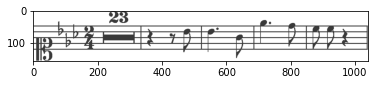

clef-C1	keySignature-EbM	timeSignature-2/4	multirest-23	barline	rest-quarter	rest-eighth	note-Bb4_eighth	barline	note-Bb4_quarter.	note-G4_eighth	barline	note-Eb5_quarter.	note-D5_eighth	barline	note-C5_eighth	note-C5_eighth	rest-quarter	barline

 clef-C1	keySignature-DM	timeSignature-3/8	multirest-11	barline	rest-quarter	rest-quarter	barline

Word Error Rate is :  1.0


In [23]:
import matplotlib.pyplot as plt
from jiwer import wer
import jiwer

def plot_predict(lst_test,pred_strings, index):
    images = lst_test["images"][index]
    ground_truth = lst_test["text"]
    ground_truth = ground_truth_decoder(ground_truth)[index]
    # [index]
    predictions = pred_strings[index]
    plot = cv2.imread(images)
    plt.imshow(plot)
    plt.show()
    print(ground_truth)
    print("\n",predictions)
    # return plot

plot_predict(lst_test,pred_strings, 0)
error = wer(ground_truth_decoder(ground_truth), pred_strings)
print("\nWord Error Rate is : ", error)

In [35]:
pred_strings1 = pred_strings
ground_truth1 = ground_truth
pred_strings1 = jiwer.RemoveWhiteSpace(replace_by_space=True)(pred_strings1)
ground_truth1 = jiwer.RemoveWhiteSpace(replace_by_space=True)(ground_truth_decoder(ground_truth1))
error = wer(ground_truth1[0], pred_strings1[0])
print(error)

0.7368421052631579


In [33]:
#separating it into words didnt work because they dont have the same size
# pred_strings1 = pred_strings
# ground_truth1 = ground_truth
# pred_strings1 = jiwer.ReduceToListOfListOfWords(word_delimiter="\t")(pred_strings1)
# ground_truth1 = jiwer.ReduceToListOfListOfWords(word_delimiter="\t")(ground_truth_decoder(ground_truth1))
# error = wer(ground_truth1[0], pred_strings1[0])
# print(error)

ValueError: number of ground truth inputs (19) and hypothesis inputs (8) must match.